---
title: "Ionosphere activity indices"
bibliography: ../bibliography.bib
---

# Table of Contents
1. [SIDX](#sidx-temporal-vtec-change)
2. [ROT](#rot-rate-of-tec)
3. [ROTI](#roti-rate-of-tec-index)
4. [GIX](#gix-vtec-spatial-gradient)
5. [Processing example](#processing-example)

# Ionospheric activity indices
One of the ways in which we can use GNSS TEC measurements is to calculate ionospheric activity indices. GNX-py implements the calculation and visualisation of SIDX (Sudden Ionosphere Disturbance Index), GIX (Gradient Ionosphere Index), and ROT/ROTI (Rate of TEC, Rate of TEC Index) indices. These indices are described in detail in the following works: [@Jakowski2019_SpatialGradientsTEC; @Cherniak2018_ROTIMaps; @Carmo2021_ROTI].  In this tutorial, we will discuss how to calculate them and show how to monitor ionospheric activity using GNX-py.

First, let us begin by discussing and deriving equations relating to SIDX, i.e. the index describing temporal changes in TEC in a given area.



Let us denote STEC, total electron content along the signal transmission path measured at time $t$, as:
$$
\mathrm{STEC}{(t)}=
\frac{\tilde{L}_4^{(n)}{(t)}}
{40.3\left(\tfrac{1}{f_1^2}-\tfrac{1}{f_2^2}\right)}\;[\mathrm{TECU}]
$$
where ${\tilde{L}_4^{(n)}{(t)}}$ is the code-leveled phase observation geometry free and $f_1$, $f_2$ are recieved signals frequencies in Hz. Conversion from STEC to VTEC is performed using the mapping function $M(e;H)$, where $e$ and $H$ are, respectively: the satellite elevation angle and the height of the ionospheric shell.
$$
\mathrm{VTEC}(t) = \frac{\mathrm{STEC}(t)}{M(e;H)} \quad [\mathrm{TECU}]
$$

$$
M(\varepsilon;H) = \frac{1}{\sqrt{1 - \left(\frac{R_E \cos e}{R_E + H}\right)^2}}
$$


The SIDX index describes the rate of change of TEC in a given area. Imagine that we have a network of GNSS stations and we record observations at 30-second intervals. Let us assume that we are tracking a certain satellite and recording the measured STEC at epochs $t_0$ and $t_1$ with one of the receivers.

In [1]:
from helpers import plot_stec_change
from tools import df_head, df_tail
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in create_collection",
    category=RuntimeWarning,
    module="shapely.creation"
)
warnings.filterwarnings(
    "ignore",
    message="The PostScript backend does not support transparency; partially transparent artists will be rendered opaque"
)


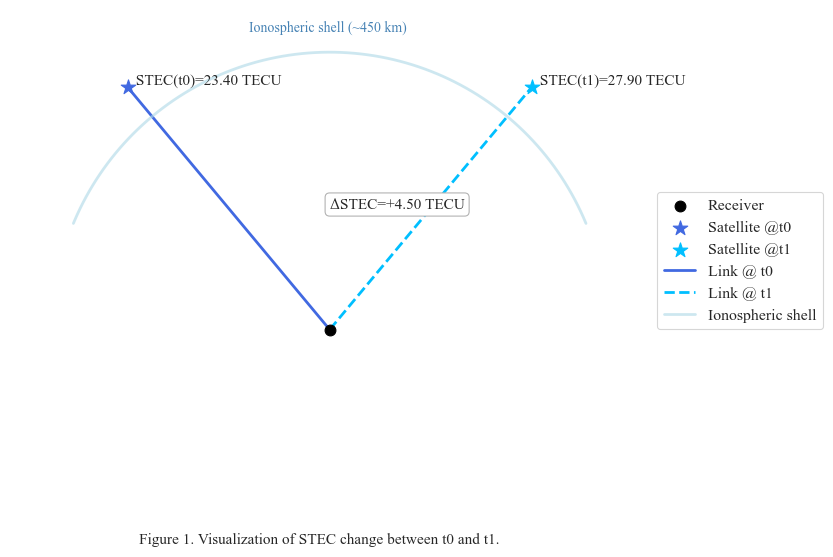

In [2]:
plot_stec_change()


By converting to VTEC and differentiating the observation from epoch $t_1$ and $t_0$ and dividing by the time interval, we obtain an approximate value for the rate of change of VTEC. Of course, satellites in neighbouring epochs are located in different places in space, and thus the location of the IPP changes, but we assume that in short intervals (at short distances between IPPs) the change in VTEC is minimal. The graph above illustrates this type of situation at the level of a single link. With the aforementioned network of stations and observing many satellites in different locations in neighbouring epochs, we obtain a set of such VTEC differences. Let us write this down step by step:

## SIDX (temporal VTEC change)

At the level of a single link:

$$
\mathrm{SID}_{\text{link}}({t_0}, {t_1}) =
\frac{\Delta \mathrm{STEC}_{{t_0}, {t_1}}}{M(e;H) \, \Delta t}
= \frac{\Delta \mathrm{VTEC}_{{t_0}, {t_1}}}{\Delta t}
\quad [\mathrm{TECU/s}]
$$

With a set of links between two neighbouring epochs, we can assign a given difference to epoch $t_1$ and use an aggregation function to represent all recorded VTEC changes in a given area.

$$
\mathrm{SIDX}({t_1}) =
\operatorname{Agg}\left\{
\mathrm{SID}_{\text{link},\,\ell}({t_0}, {t_1}) \; : \; \ell \in \mathcal{L}({t_0}, {t_1})
\right\}
\quad [\mathrm{TECU/s}]
$$
Where $\ell$ is a single link and $\mathcal{L}({t_0}, {t_1})$ is the set of all links between
two neighbouring epochs and $\operatorname{Agg} \in \{\mathrm{median}, \mathrm{mean}, \mathrm{p95}, \max\}$ is the aggregation function.

In GNX-py, we use the $95\%$ percentile by default for SIDX visualisation. We also scale the calculated changes to mTECU/s.

$$
\mathrm{SIDX}_{\mathrm{min}}(t) = 1000 \cdot \mathrm{SIDX}(t)
\quad [\mathrm{mTECU/s}]
$$

Finally, all calculated and aggregated differences constitute our SIDX index for a given reference epoch ($t_1$). Note that I have omitted the receiver and satellite DCB in the equations – they cancel out during the differentiation operation. Since we can assume their constancy over a 24-hour period (X,Y,Z), we can calculate the SIDX index on uncalibrated observations. The same assumption will also apply below when discussing ROTI and GIX, which we will now move on to.



## ROT (Rate Of TEC)
SIDX is a certain (mean, median, percentile) measure representing temporal changes in VTEC in a given area; it can be represented as an aggregation of ROT values:
$$
\mathrm{ROT}(t) \approx \frac{\Delta \mathrm{STEC}}{\Delta t}
= \frac{\mathrm{STEC}(t) - \mathrm{STEC}(t-\Delta t)}{\Delta t}
\quad [\mathrm{TECU/s}]
$$

$$
\mathrm{ROT}_{\mathrm{min}}(t) = 60 \cdot \mathrm{ROT}(t)
\quad [\mathrm{TECU/min}]
$$

ROTI, on the other hand, is calculated as the standard deviation of ROT in a given time window, e.g. 5 minutes. In GNX-py, we work with VTEC for SIDX, and with STEC for ROT and ROTI, following the convention presented in X and Y.
## ROTI (Rate Of TEC Index)

$$
\mathrm{ROTI}(t) =
\sqrt{\frac{1}{N-1} \sum_{k=1}^{N}
\left(\mathrm{ROT}_{\mathrm{min}}(t_k) - \overline{\mathrm{ROT}_{\mathrm{min}}}\right)^2}
\quad [\mathrm{TECU/min}]
$$

gdzie:
- ${t_k}$ — epochs in given time window,
- $\overline{\mathrm{ROT}_{\mathrm{min}}}$ — mean ROT in given time window.

As with SIDX, in the case of ROT we also work with receiver-satellite pairs.
In GNX-py, ROTI is presented in the form of a coordinate grid in a geographic or solar-geomagnetic system. The ROTI values calculated in the window can be assigned to grid points according to the following approaches:
- the ROT value is assigned to the ‘centre’ position, i.e. halfway along the satellite tracking path on the ionospheric shell
- at the initial position in the window (in the first IPP for a given satellite-receiver link)


## GIX (VTEC spatial gradient)
The last of the indices available in GNX-py is the GIX family of indices: GIX, GIXS, and GIX95. These are indices describing the spatial variation of VTEC in a given area. Unlike ROT and SIDX, in case of GIX we process data from a single epoch. Again, let us assume that we have a network of stations recording GNSS satellites signals. In each epoch, we observe a set of satellites from each station and obtain the corresponding STEC measurements along with their IPP according to the assumed model (by default, thin-shell 450 km). The GIX is calculated as follows:

Having pair of IPPs \( i, j \) (see figure below):

$$
\Delta \mathrm{VTEC} = \mathrm{VTEC}_i - \mathrm{VTEC}_j
$$


We can calculate the VTEC gradient in the direction of $ j \rightarrow i $:

$$
g_{ij} = \frac{\Delta \mathrm{VTEC}}{\Delta s}
\quad [\mathrm{TECU/km}]
\qquad
\Delta s \approx s_{ij}
$$
where $\Delta s$ is the distance between IPPs

By calculating the azimuth $\alpha_{j \to i}$ of the line connecting two points, we can decompose the gradient into a gradient in the direction WE/NS:

$$
g_{WE} = g_{ij} \sin\alpha_{j \to i}, \qquad
g_{NS} = g_{ij} \cos\alpha_{j \to i}
\quad [\mathrm{TECU/km}]
$$
The calculated gradient is located at the central point $CP_{i,j}$ (see figure) between the IPP points.
Then all pairs $( i, j )$ from the set $\mathcal{P}(t)$ from a given epoch are aggregated using the mean function:

$$
\overline{g}_{WE}(t) =
\operatorname{mean}\{g_{WE}\}_{(i,j)\in\mathcal{P}(t)}, \qquad
\overline{g}_{NS}(t) =
\operatorname{mean}\{g_{NS}\}_{(i,j)\in\mathcal{P}(t)}
$$

Finally, the GIX index for a given epoch is calculated as:

$$
\mathrm{GIX}(t) =
\sqrt{\overline{g}_{WE}(t)^2 + \overline{g}_{NS}(t)^2}
\quad [\mathrm{TECU/km}]
$$


$$
\mathrm{GIXS}(t) =
\operatorname{std}\{|g_{ij}|\}_{(i,j)\in\mathcal{P}(t)}
\quad [\mathrm{TECU/km}]
$$

$$
\mathrm{GIXP95}(t) =
\operatorname{percentile}_{95}\{|g_{ij}|\}_{(i,j)\in\mathcal{P}(t)}
\quad [\mathrm{TECU/km}]
$$

The figure below illustrates an example on a micro scale – for a pair of points. In GNX-py, criterion for selecting pairs is based on the distance between points. The user can set this range themselves or select the default, e.g. a range from 30 to 250 km. The above calculations are therefore performed for all pairs created in a given epoch.

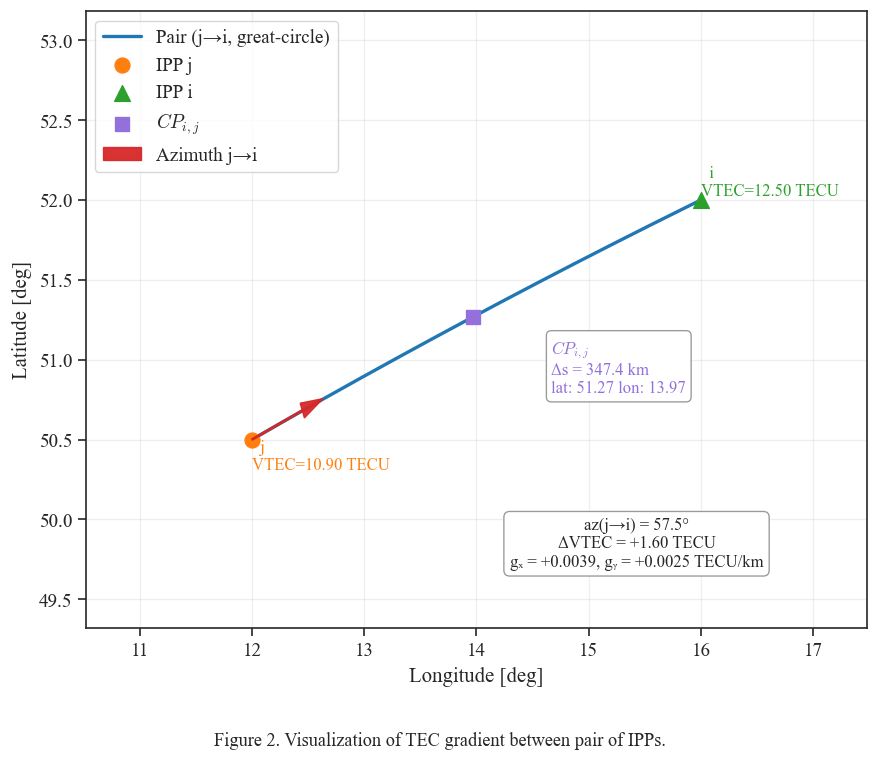

In [3]:
from helpers import plot_gix_two_points
plot_gix_two_points(
    draw_gc_arc=True,
    show_cp_arrow=False,
    title="GIX for two IPPs (with CP)"
)


To learn more about the issues related to the indices described above, please refer to works X, Y, and Z. Most of the methodology is based on these works. Now we will show how the above indices can be obtained in GNX-py. To speed up the tutorial and save space, we will perform calculations on a very limited GNSS station network. Due to the fact that the calculations are based on built-in pandas tools, for large networks (e.g. 100 or more stations) calculations for the entire day at 30-second intervals can take up to several dozen minutes. Therefore, we will focus on a small network and a short period of time so that you can learn how to call functions, save and visualise data, which will help you implement algorithms for your own needs.

## Processing example

In [4]:
import matplotlib.pyplot as plt
import gps_lib as gnx
import pandas as pd
import numpy as np

Let's start by loading the data. To calculate indices representing ionospheric activity over a given region, we must, of course, have access to the network of stations in that region. In this example, in the ./network folder, you'll find several files with processed measurements from EUREF network stations. These data was processed using the $STECSession class$, with reciever's DCB's obtained from PPP-UDUC measurements. Carefully studying the equations presented above, you'll notice that the receiver's and satellite's DCB's, as constant biases, cancel out during the time-differentiation operation performed for SIDX and ROTI calculation. We can therefore work with uncalibrated measurements, as we're interested in the change, not the absolute value, of TEC. However for GIX family calculation we must have calibrated STEC measurements. Data loading is performed using the $load\_stec\_folder$ function, whose parameters are described below:

In [5]:

data_path = './network'
data, info  = gnx.load_stec_folder(folder=data_path,
                                   file_suffix="STEC.parquet.gzip",
                                   min_elev_deg=30,
                                   station_name_len=6,
                                   unique_id_len=4,
                                   quiet=True,
                                   skip_negative=True,
                                   required_columns = ("lat_ipp", "lon_ipp", "leveled_tec", "ev","sv","time"))


This function is designed to read sets of output files from individual station processing, saved by default in Parquet format. This format takes up less space than CSV, and it's useful as we usually want to access more than one station. The function arguments shown are default values, except, of course, for the folder path. The arguments define an elevation mask, name filtering using $network\_fiter$ to load a subset of data from selected stations, and the $skip\_negative$ flag to skip files containing negative TEC, which indicates an incorrect DCB or other station/measurement malfunction. $file\_suffix$ parameter is intended for situations when you have various parquet files in a folder, e.g. positioning results. Let's take a look at the obtained data. The info dictionary contains information about the upload process—the number of stations accepted and rejected, etc. You can study the keys below:

In [6]:
df_head(data[['leveled_tec','lat_ipp','lon_ipp','name']],nrows=4)

| sv      | time                |   leveled_tec |   lat_ipp |   lon_ipp | name   |
|---------|---------------------|---------------|-----------|-----------|--------|
| E02_0_1 | 2024-02-04 08:35:30 |        48.201 |    46.225 |     9.380 | BAUT_E |
| E02_0_1 | 2024-02-04 08:36:00 |        48.157 |    46.261 |     9.398 | BAUT_E |
| E02_0_1 | 2024-02-04 08:36:30 |        47.955 |    46.297 |     9.415 | BAUT_E |
| E02_0_1 | 2024-02-04 08:37:00 |        47.882 |    46.333 |     9.432 | BAUT_E |

In [7]:
info.keys()

dict_keys(['files_scanned', 'files_accepted', 'files_rejected', 'stations_unique', 'stations_accepted', 'stations_rejected', 'rejected_files', 'errors'])

As you can see, our data includes the satellite PRN, station ID, STEC measurements (code and phase), and the geocentric IPP coordinates. Let's perform some additional preparations for calculating the indices, specifically, calculate the mapping function for our model (450 km thin-shell) and VTEC.

In [8]:
data = data.reset_index()
data['time'] = pd.to_datetime(data['time'])

df= data.copy()
R=6371
ish = 450
m_f = 1 / np.sqrt(1 - (R / (R + ish)) ** 2 * np.cos(np.deg2rad(df['ev'])) ** 2)
df['M'] = m_f
df['stec'] = df['leveled_tec']
df['vtec'] = df['stec']/df['M']


Using the Region class from the $monitoring.py$ module, we define the area over which we want to determine our indexes. This area is already implicitly defined by the selected stations, but when processing larger networks, it's worth specifying the study area more precisely, as we may sometimes have access to measurements very distant from the locations of interest, which still require computational time.

In [9]:
reg = gnx.Region(lat_min=50,lat_max=57.5,lon_min=10,lon_max=30)

We're ready to calculate ROTI. We do this in the $compute\_roti\_links$ function. We define:


- $df$-our dataframe with observations,
- $reg$-region class instance,
- $tec\_source$-name of the source observation column (stec or vtec),
- $tec\_scale$-scale in which we report stec or vtec (1 for TECU, 1e16 for electrons),
- $window\_min$-the window for the standard deviation and the minimum number of observations needed for the deviation (note - once this window is reached, std will be calculated in a smaller window than defined),
- $min\_elev\_deg$_elevation mask,
- $coord\_mode$_reference system (geographic or solar-geomagnetic),
- $detrend\_5min$-flag indicating whether to use a 5-minute moving average for detrending stec.

In [10]:

roti = gnx.compute_roti_links(
    df=df,
    region=reg,
    tec_source='stec',
    tec_scale = 1,
    window_min=5,
    min_samples=10,
    max_gap_s=31,
    split_on_day_change = False,
    min_elev_deg=30,
    detrend_5min=True,
    coord_mode='GEO'

)

In [11]:
df_tail(roti[['time','lat_ipp','lon_ipp','ROT_tecu_per_min','ROTI_tecu_per_min']],nrows=3,ncols=10,reset_index=False,index=False,truncate_str=3)

| time                      |   lat_ipp |   lon_ipp |   ROT_tecu_per_min |   ROTI_tecu_per_min |
|---------------------------|-----------|-----------|--------------------|---------------------|
| 2024-02-04 23:59:30+00:00 |    51.828 |    14.679 |              0.058 |               0.084 |
| 2024-02-04 23:59:30+00:00 |    50.185 |    21.901 |             -0.028 |               0.050 |
| 2024-02-04 23:59:30+00:00 |    50.265 |    18.852 |              0.065 |               0.074 |

Let's look at the results. Each row represents a satellite-receiver pair at a given epoch. Let's choose a sample station and look at the first 10 minutes of observations. As you can see, ROTI is calculated within a 5-minute window, as we chose. The first value is obtained after 5 minutes and is assigned to the epoch 00:05:00, and comes from calculating the standard deviation over the last 5 minutes of calculated ROTI. Subsequent ROTI observations are calculated in the same way – each epoch contains $std(ROT)$ from the last $window\_min$ minutes.

In [12]:
roti_sample = roti[(roti['name'] == 'BOGE_E') & (roti['sv'].str.startswith('E10'))].sort_values(by='time')[['time','name','sv','ROTI_tecu_per_min']]
df_head(roti_sample,nrows=12,ncols=10)

|    index | time                      | name   | sv      |   ROTI_tecu_per_min |
|----------|---------------------------|--------|---------|---------------------|
|    4.000 | 2024-02-04 00:00:00+00:00 | BOGE_E | E10_0_1 |             nan     |
|  171.000 | 2024-02-04 00:00:30+00:00 | BOGE_E | E10_0_1 |             nan     |
|  344.000 | 2024-02-04 00:01:00+00:00 | BOGE_E | E10_0_1 |             nan     |
|  519.000 | 2024-02-04 00:01:30+00:00 | BOGE_E | E10_0_1 |             nan     |
|  698.000 | 2024-02-04 00:02:00+00:00 | BOGE_E | E10_0_1 |             nan     |
|  880.000 | 2024-02-04 00:02:30+00:00 | BOGE_E | E10_0_1 |             nan     |
| 1064.000 | 2024-02-04 00:03:00+00:00 | BOGE_E | E10_0_1 |             nan     |
| 1244.000 | 2024-02-04 00:03:30+00:00 | BOGE_E | E10_0_1 |             nan     |
| 1425.000 | 2024-02-04 00:04:00+00:00 | BOGE_E | E10_0_1 |             nan     |
| 1608.000 | 2024-02-04 00:04:30+00:00 | BOGE_E | E10_0_1 |             nan     |
| 1787.000 | 2024-02-04 00:05:00+00:00 | BOGE_E | E10_0_1 |               0.003 |
| 1968.000 | 2024-02-04 00:05:30+00:00 | BOGE_E | E10_0_1 |               0.005 |

Using pandas tools, we can create a first simple visualization of our data - let's look at the mean and 95th percentile of ROTI in each epoch.

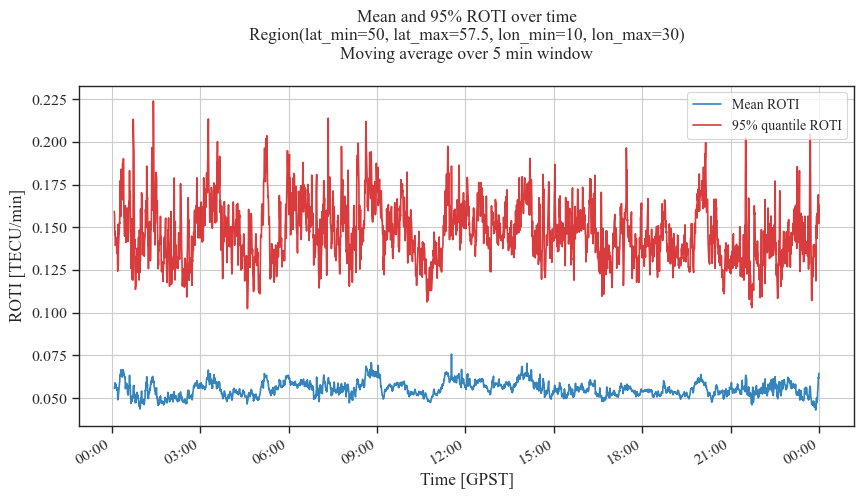

In [13]:

roti['mn']  = roti.groupby('time')['ROTI_tecu_per_min'].transform('mean')
roti['q95'] = roti.groupby('time')['ROTI_tecu_per_min'].transform(lambda s: s.quantile(0.95))
to_plot = (
    roti
    .set_index('time')[['mn', 'q95']]
    .sort_index()
    .rename(columns={
        'mn':  'Mean',
        'q95': 'ROTI_95'
    })
)
ax = to_plot.plot(
    figsize=(10, 5),
    ylabel='ROTI [TECU/min]',
    xlabel='Time [GPST]',
    title=(
        f'Mean and 95% ROTI over time\n{reg}\n'
        'Moving average over 5 min window\n'
    ),
    color=['tab:blue', 'tab:red'],
    lw=1.2,
    alpha=0.9,
    grid=True,
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(
    [r'Mean ROTI', r'95% quantile ROTI'],
    loc='upper right',
    fontsize=10,
    frameon=True
)


As you can see, the graph allows you to observe the evolution of the ROTI over time. Day 2024 035 is a quiet day for geomagnetic activity (Ap ~6), so it's not surprising that we observe a relatively stable graph without any anomalies. You can also plot the graph in mTECU/s units if you want to observe the index at a different time resolution. A key feature of the module in case of ROTI is the ability to visualize it in the form of snapshot images covering a given time window. This is achieved using the $make\_roti\_snapshots$ function. We insert our resulting dataframe into the function and define several plotting parameters. Let's now discuss the most important ones:
- $roti\_df$ is a dataframe with roti results
- $every\_n$ - is the interval at which we save maps in epochs (e.g., with a 30-s sampling rate, 10 epochs = a 5-minute window)
- $mode$ ('center', 'trailing', or 'top') is the mechanism for assigning snapshots to epochs, at the middle, beginning, or end of the window, respectively. As mentioned, ROTI is assigned to the end of the window by default, so 'top' is most appropriate.
- $global\_scale$ - whether to globally calculate the ROTI value range (used to build the legend)
- $q\_scale$ - together with the global scale used to build the legend range, indicates the lower and upper percentiles of ROTI values, which constitute the boundaries of the values ​​in the chart legend
- $out\_dir$ - image output path
- $vmin, vmax$ - ROTI min and max range, overrides the algorithm for automatically determining the scale on the chart
- $agg$ - aggregation function, defaulting to 'mean'. For each point in our ROTI grid, we aggregate the observed values ​​using the aggregate function. When tracking a given satellite and having several ROTI observations, we average them and assign them to a given time (mode) and grid location.
- $res\_deg$ - grid resolution
- $min\_points$ - minimum number of points per square (res_deg x res_deg) needed to assign a value to the grid
- $coord\_mode$ - coordinate system in which we plot the grid (GEO or SM)

In [14]:
roti_copy = roti[(roti['time'].dt.hour>=10) & (roti['time'].dt.hour<=13)].copy()
extent = [9, 29, 49,58.5]
gnx.make_roti_snapshots(
    roti_df=roti_copy,
    every_n=30,                   # every 30 epochs  => 30*0.5min = 15 min
    window_min=5,
    mode='center',
    res_deg=2,
    min_points=3,
    global_scale=False,
    q_scale=(5,99),
    out_dir="./figures/roti",
    # vmin=0,
    # vmax=0.3,
    agg='Q95',
    coord_mode = 'GEO',
    extent=extent,
)

You can view the created images in the .figures/roti directory, below you will see randomly selected figure. The images are generated as follows: each square with dimensions corresponding to the resolution $res\_deg$ is assigned a value aggregated using the $agg$ function. If we have $min\_points$ points for which we calculated ROTI in a given area covering a tile, we aggregate the values and assign them to the tile. Together with the linear graph you saw above, this graph is useful in spatial visualisation.


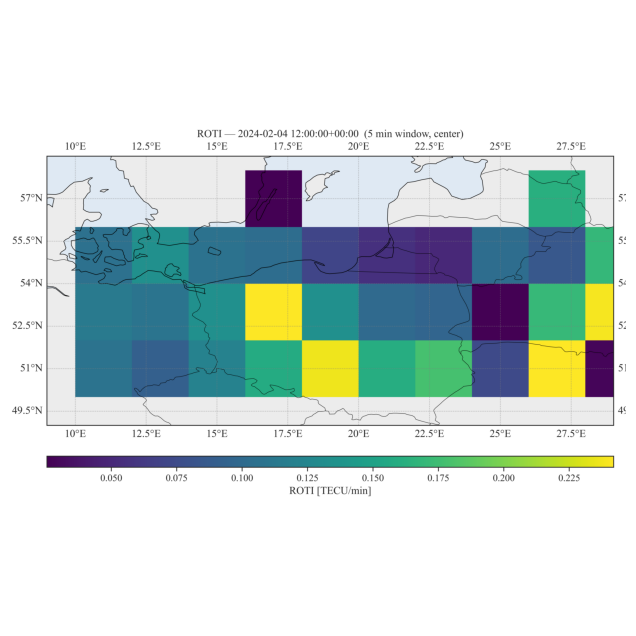

In [16]:
import matplotlib.image as mpimg
path ='./figures/roti/roti_20240204_120000.png'
img = mpimg.imread(path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

As explained in the introduction, SIDX is also an indicator of TEC temporal variability. With data from multiple stations available, we calculate it in GNX-py in the same way as ROTI. The arguments of the function calculating SIDX are the same as in the function calculating ROTI links.

In [17]:

sidx = gnx.compute_sid(df=df,
    region=reg,
    min_elev_deg=30,
    iono_h_m=450,
    stec_scale=1,
    max_gap_s=30,
    split_on_day_change= True,
    agg= "p95")


In [18]:
df_head(sidx,nrows=3,ncols=2)

| time                      |   SIDX_tecu_per_min |
|---------------------------|---------------------|
| 2024-02-04 00:00:30+00:00 |               3.821 |
| 2024-02-04 00:01:00+00:00 |               3.474 |
| 2024-02-04 00:01:30+00:00 |               3.040 |

The result is a pd.Series with SIDX calculated for each epoch. Visualisation can be provided by built-in pandas tools.


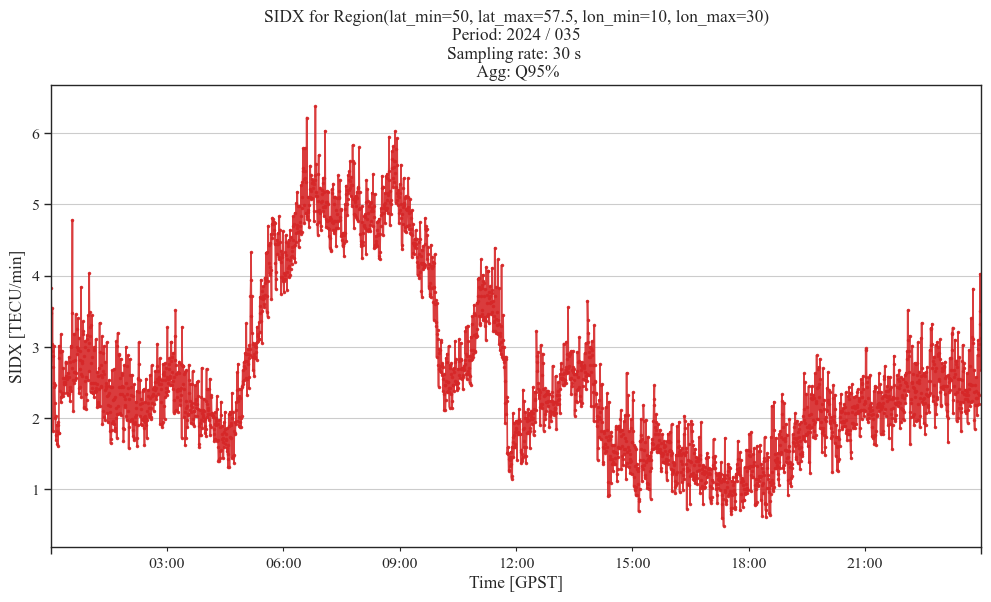

In [19]:
ax=sidx.plot(
    x='time',
    y='SIDX_tecu_per_min',
    figsize=(12, 6),
    color='tab:red',
    alpha=0.9,
    lw=1.2,
    marker='.',
    markersize=3,
    ylabel='SIDX [TECU/min]',
    xlabel='Time [GPST]',
    title=(
        f'SIDX for {reg}\n'
        'Period: 2024 / 035\n'
        'Sampling rate: 30 s \n Agg: Q95%'
    ),
    grid=True
)



The GIX index, like the previous ones, is calculated using a dedicated function. The function arguments are almost identical to those for ROTI and SIDX, with a few minor exceptions. We will now discuss the arguments unique to GIX:
- $dipole\_preset$ - dipole length range (distance between IPP pairs). The choice is between three defined ranges: 30-250, 50-500, 100-1000 km.
- $dmin\_km, max\_km$ - as an alternative to the dipole length, you can select your own lower and upper distance limits for which IPP pairs are formed. Overwrites dipole_preset
- $max\_delta\_M$ - maximum difference in the mapping function between two IPPs - the range 0.0-0.2 is safe in terms of minimising the impact of an incorrectly estimated receiver DCB. Unlike ROTI and SIDX, we have to operate on calibrated measurements here, because in the measurements we differentiate between observations from different satellite-receiver pairs
- $stratified\_sampling$ - point thinning, together with $max\_pairs\_per\_epoch$, is a condition for the maximum number of points per epoch, which can be useful when there are a large number of measurements.


In [20]:

df_copy = df[(df['time'].dt.hour>=12) & (df['time'].dt.hour<=13)].copy()

In [21]:
dmin, dmax = 150, 500

times, pairs = gnx.compute_gix(
    df=df_copy,
    region=reg,
    min_elev_deg=30,
    # dipole_preset = "30-250",
    dmin_km = dmin,
    dmax_km =dmax,
    iono_h_m=450,
    stec_scale = 1.0,
    max_delta_M= 0.1,
    max_pairs_per_epoch = 200e3,
    stratified_sampling =True
)



Our output consists of two dataframes. The $times$ dataframe contains a family of GIX indices for each epoch. It includes:
- GIX
- average GIX in the E-W and N-S directions (subscripts x and y, respectively)
- GIXS with directional components
- GIXP95 with directional components, as well as negative and positive components, i.e. the 5th and 95th percentiles for positive and negative gradients, respectively, in the E-W (x) and N-E (y)
- npairs - number of pairs in a given epoch that were used to calculate the indices

In addition to the built-in pandas tools, you can visualise the indices using a function from the GNX-py library.

In [22]:
df_head(times[['time','GIX_mtecu_km','GIXS_mtecu_km']],nrows=3,ncols=7)

|   index | time                      |   GIX_mtecu_km |   GIXS_mtecu_km |
|---------|---------------------------|----------------|-----------------|
|   0.000 | 2024-02-04 12:00:00+00:00 |          3.314 |           6.794 |
|   1.000 | 2024-02-04 12:00:30+00:00 |          3.288 |           6.807 |
|   2.000 | 2024-02-04 12:01:00+00:00 |          3.306 |           6.825 |

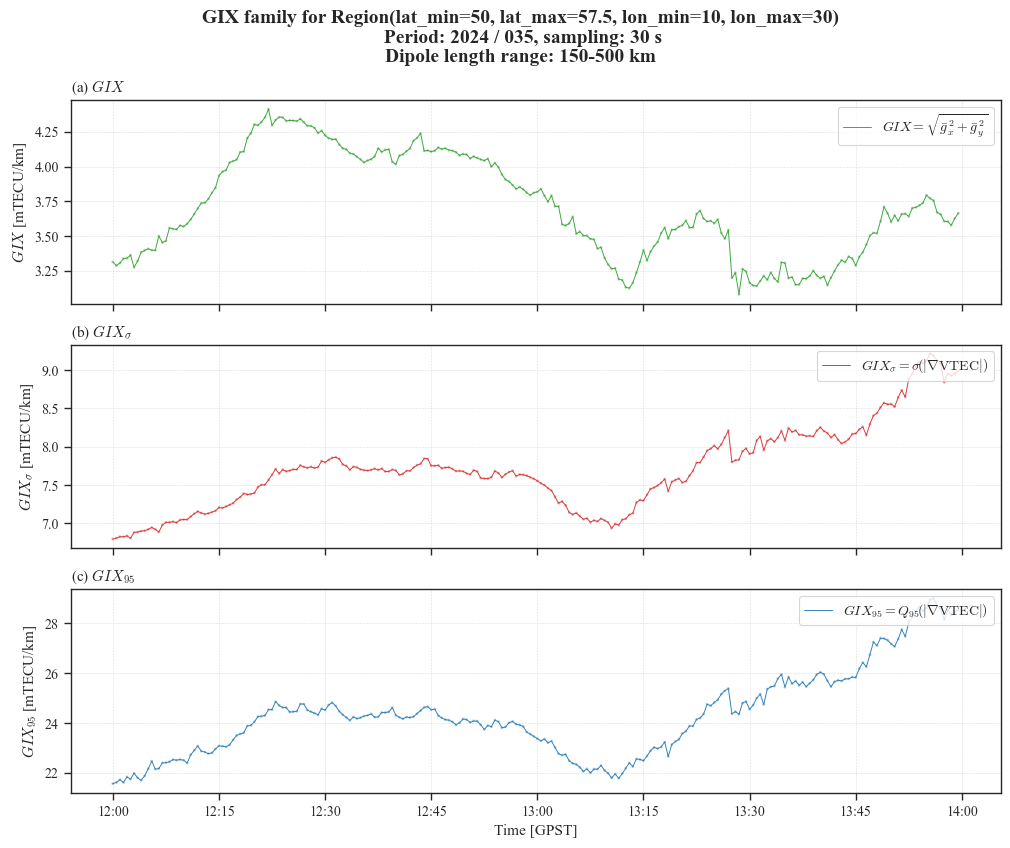

In [23]:
fig, axes = gnx.plot_gix_family(times, reg=reg, dmin=dmin, dmax=dmax)
plt.show()


In the $pairs$ dataframe, you will find data on each pair that was created in each epoch. Each row contains the dipole centre coordinates, CP_lat and CP_lon, the absolute VTEC gradient calculated in the dipole direction, as shown in the figure in the introductory section, directional gradients, dipole length, mapping function values, station and satellite names, and VTEC differences between IPPs.

This data can be used for spatial visualisation of GIX. The $plot\_gix$ function from the GNX-py library is used for this purpose. Keep in mind that we are operating on dipoles of different lengths (you can modify this range with $dmin\_km$ and $dmax\_km$), so when interpreting the image, do not be confused by the colours of individual points. What you are looking at are GIX values calculated for pairs of points separated by $dmin\_km$ and $dmax\_km$. I encourage you to change the dipole length range and examine the plots and $pairs$ dataframe after that.  This will give you an intuitive insight into how GIX is calculated.

In [24]:
df_head(pairs[['time','CP_lat','CP_lon','grad_abs_mtecu_km']],nrows=3,ncols=7)

|   index | time                      |   CP_lat |   CP_lon |   grad_abs_mtecu_km |
|---------|---------------------------|----------|----------|---------------------|
|   0.000 | 2024-02-04 12:00:00+00:00 |   50.706 |   16.104 |               0.197 |
|   1.000 | 2024-02-04 12:00:00+00:00 |   52.207 |   18.852 |               6.390 |
|   2.000 | 2024-02-04 12:00:00+00:00 |   52.184 |   18.324 |               5.389 |

The displayed value is the column $grad\_abs\_mtecu\_km$, i.e. the absolute value of the gradient per kilometre in mTECU units. The images below can be interpreted as follows. When we see a large accumulation of bright spots in a given area, we can assume that there is a high VTEC gradient in that region, within a radius of $dmin\_km, dmax\_km$ from the spot, and similarly, in the case of dark spots, a low TEC gradient.



In [27]:
epochs = pairs['time'].unique()
epoch = epochs[180]
fig, ax, sc = gnx.plot_gix(pairs, epoch,save_path='./figures/gix/gix_epochs.png',extent=extent)


As you can see, all our data is created in the pandas dataframe or series format. You can save data in any format supported by pandas. I recommend CSV or parquet.gzip, especially the latter in terms of space optimisation.

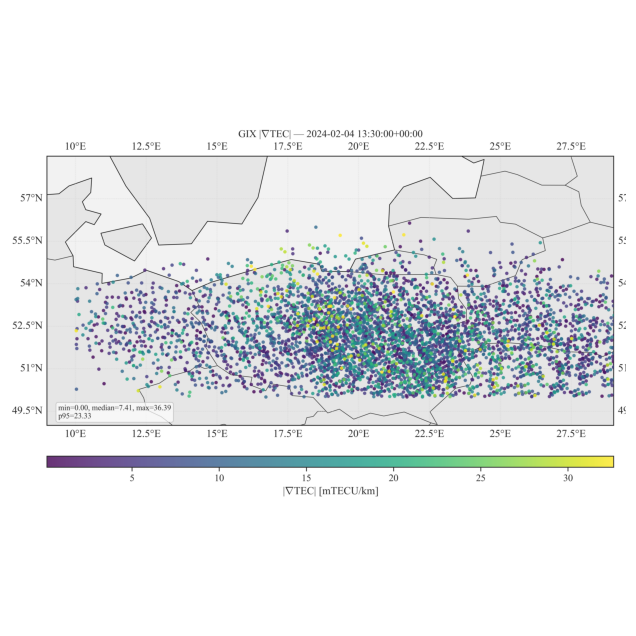

In [28]:
import matplotlib.image as mpimg
path ='./figures/gix/gix_epochs.png'
img = mpimg.imread(path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [29]:
out='./output'
sidx.to_frame().to_parquet(f'{out}/sidx.parquet.gzip')
times.to_parquet(f'{out}/times.parquet.gzip')
pairs.to_parquet(f'{out}/pairs.parquet.gzip')
roti.to_parquet(f'{out}/roti.parquet.gzip')

In the next notebook, we will discuss the use of kriging to create VTEC models based on measurements from a network of GNSS stations.

